# XGBoost pour la rétention de clients

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SVMSMOTE

In [80]:
#Chargement des données
df=pd.read_csv('Churn_Modelling.csv')

print(df.head(10))

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   
5          6    15574012       Chu          645     Spain    Male   44   
6          7    15592531  Bartlett          822    France    Male   50   
7          8    15656148    Obinna          376   Germany  Female   29   
8          9    15792365        He          501    France    Male   44   
9         10    15592389        H?          684    France    Male   27   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0       

# Analyse exploratoire

In [81]:
#Ces trois variables sont inutiles, on les supprime
del df["RowNumber"]
del df["CustomerId"]
del df["Surname"]

In [82]:
#Analyse exploratoire
def analyse_dataframe(df):
    
    print("Les dimensions du Dataframe sont : ",df.shape)    
    print('\n')
    print("Les informations sont : ")
    print(df.info())
    print("\n")
    print("Resume statistique :")
    print(df.describe())
    
    #Analyse des valeurs manquantes
    print("\n")
    print("Nombre de valeurs nulles par colonne :")
    print(df.isnull().sum())
    
    #Nombre de valeurs différentes par variable
    print("\n")
    print("Nombre de modalités par variable :")
    print(df.nunique())
    
    return 0

analyse_dataframe(df)

Les dimensions du Dataframe sont :  (10000, 11)


Les informations sont : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None


Resume statistique :
        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.00000

0

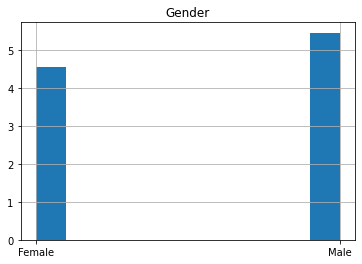

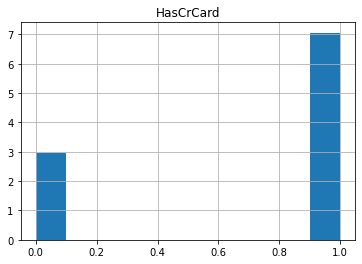

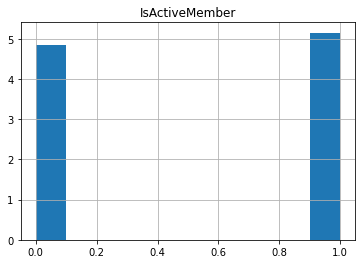

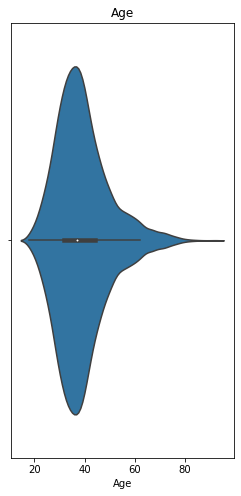

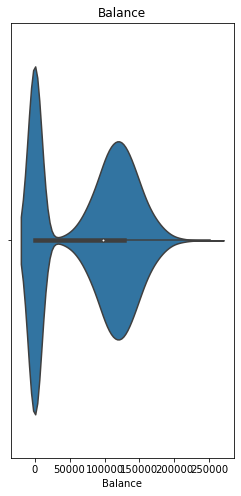

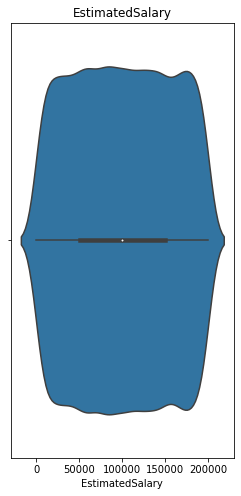

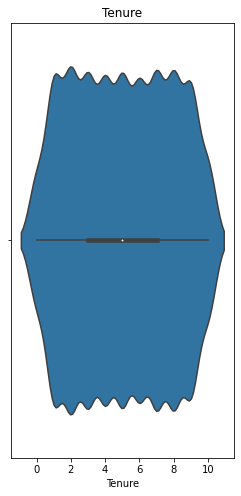

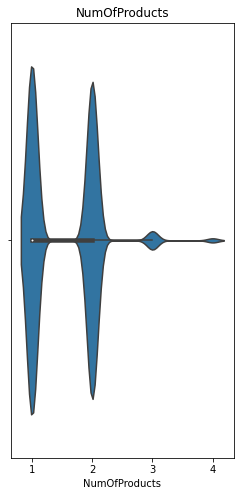

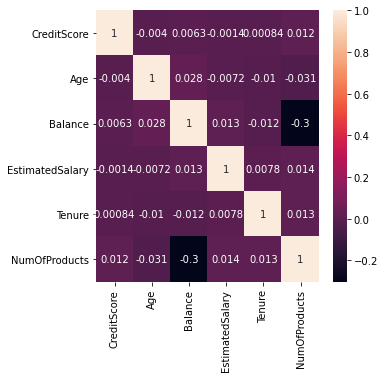

0

In [83]:
def analyse_dataframe2(df):
    Cat_feat = ['Geography','Gender','HasCrCard','IsActiveMember']
    Num_feat = ['CreditScore','Age','Balance','EstimatedSalary','Tenure','NumOfProducts']
    
    df_cat = df[Cat_feat]
    df_num = df[Num_feat]
    
    #Pour les variables qualitatives
    for i in range (1,df_cat.shape[1]):
        #Variable quanlitative : histogramme
        df[df_cat.columns[i]].hist(density=True)
        plt.title(df_cat.columns[i])
        plt.show()
        plt.close()
            
    #Pour les variables quantitatives
    for i in range (1,df_num.shape[1]):
        plt.figure(figsize=(4, 8))
        sns.violinplot(df_num[df_num.columns[i]])
        plt.title(df_num.columns[i])
    
    #Analyse des correlations
    plt.figure(figsize=(5, 5))
    corrMatrix = df_num.corr()
    sns.heatmap(corrMatrix, annot=True)
    plt.show()
    plt.close()
    
    return 0

analyse_dataframe2(df)

Text(0.5, 1.0, 'Countplot de IsActiveMember')

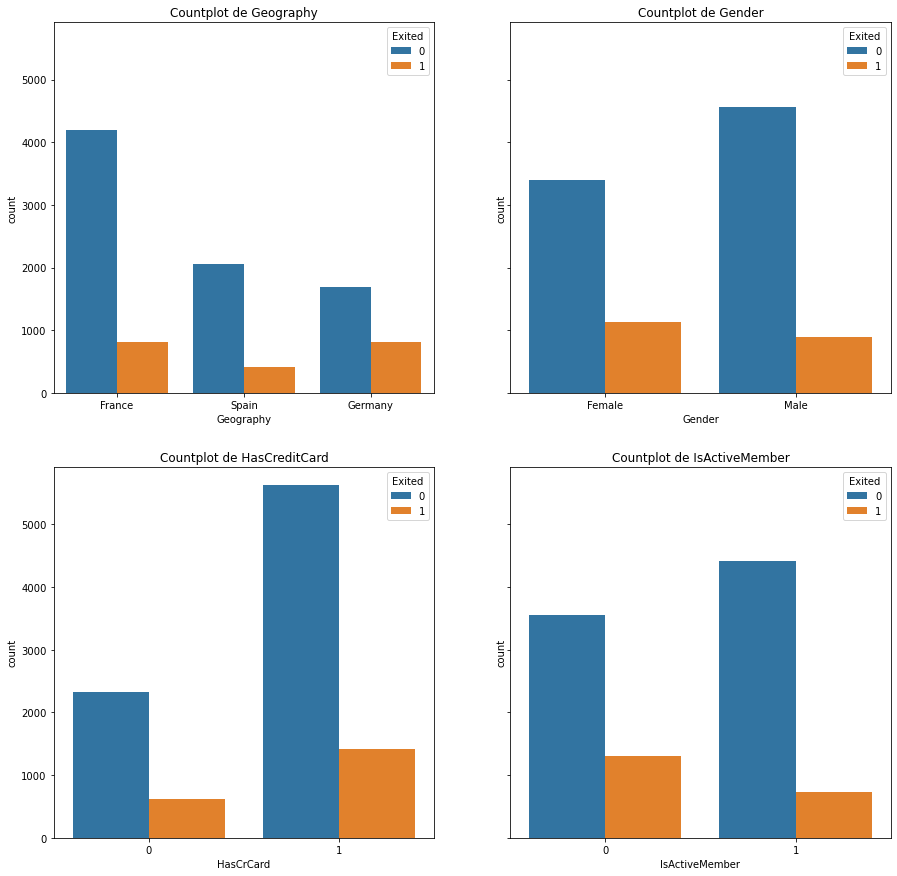

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
sns.countplot(ax=axes[0, 0],x='Geography', hue = 'Exited',data = df).set_title('Countplot de Geography')
sns.countplot(ax=axes[0, 1],x='Gender', hue = 'Exited',data = df).set_title('Countplot de Gender')
sns.countplot(ax=axes[1, 0],x='HasCrCard', hue = 'Exited',data = df).set_title('Countplot de HasCreditCard')
sns.countplot(ax=axes[1, 1],x='IsActiveMember', hue = 'Exited',data = df).set_title('Countplot de IsActiveMember')

Text(0.5, 1.0, 'Boxplot de EstimatedSalary')

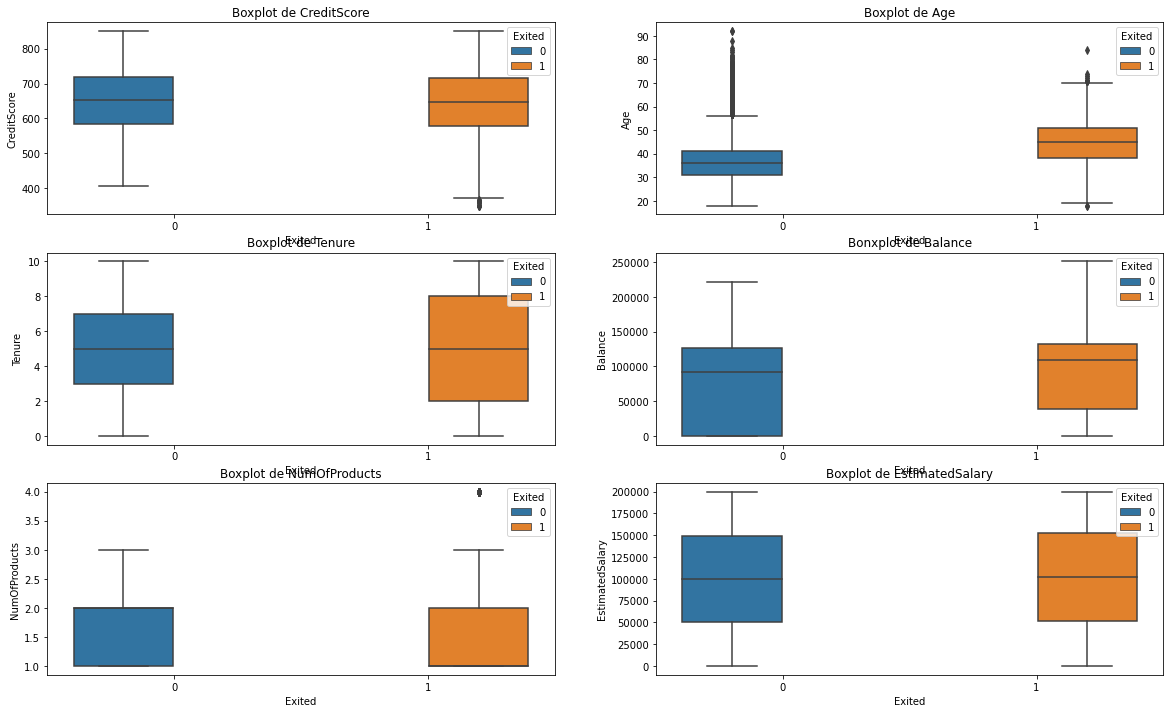

In [85]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(ax=axes[0,0], y='CreditScore',x = 'Exited', hue = 'Exited',data = df).set_title('Boxplot de CreditScore')
sns.boxplot(ax=axes[0,1], y='Age',x = 'Exited', hue = 'Exited',data = df).set_title('Boxplot de Age')
sns.boxplot(ax=axes[1,0], y='Tenure',x = 'Exited', hue = 'Exited',data = df).set_title('Boxplot de Tenure')
sns.boxplot(ax=axes[1,1], y='Balance',x = 'Exited', hue = 'Exited',data = df).set_title('Bonxplot de Balance')
sns.boxplot(ax=axes[2,0], y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df).set_title('Boxplot de NumOfProducts')
sns.boxplot(ax=axes[2,1], y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df).set_title('Boxplot de EstimatedSalary')

# Data Preprocessing

In [86]:
y = df['Exited'].values
del df['Exited']

X_train, X_test, y_train, y_test = train_test_split(df,y,test_size=0.25,random_state=42)

print(X_test)

      CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
6252          596   Germany    Male   32       3   96709.07              2   
4684          623    France    Male   43       1       0.00              2   
1731          601     Spain  Female   44       4       0.00              2   
4742          506   Germany    Male   59       8  119152.10              2   
4521          560     Spain  Female   27       7  124995.98              1   
...           ...       ...     ...  ...     ...        ...            ...   
4862          645     Spain  Female   55       1  133676.65              1   
7025          569     Spain  Female   51       3       0.00              3   
7647          768    France    Male   25       0   78396.08              1   
7161          690    France  Female   36       6  110480.48              1   
73            604   Germany  Female   25       5  157780.84              2   

      HasCrCard  IsActiveMember  EstimatedSalary  
6252        

In [87]:
def feature_engineering_and_discretization(df2):
    df = df2.copy()
    df["CreditScoreDiscr"] = pd.qcut(df["CreditScore"], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    df["AgeScoreDiscr"] = pd.qcut(df["Age"], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    df["BalanceScoreDiscr"] = pd.qcut(df["Balance"], 2, labels = [1, 2])
    df["EstimatedSalaryDiscr"] = pd.qcut(df["EstimatedSalary"], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    df["Balance_parrapport_salaire"] = df["Balance"]/df["EstimatedSalary"]
    df["Tenure_par_age"] = df["Tenure"]/(df["Age"])
    df["CreditScore_par_Age"] = df["CreditScore"]/(df["Age"])
    df["Salaire_par_age"] = df["EstimatedSalary"]/(df["Age"])
    return df
transformer_fe = FunctionTransformer(feature_engineering_and_discretization)

def null_func(x):
    return x
transformer_null = FunctionTransformer(null_func)

Cat_feat = ['HasCrCard','IsActiveMember']
Num_feat = ['CreditScore','Age','Balance','EstimatedSalary','Tenure','NumOfProducts']
Ohe_feat = ['Geography','Gender']

ohe_pipe = Pipeline([('encoder', OneHotEncoder(drop='first', sparse=False))])

num_pipe = Pipeline([('scaler', StandardScaler())])

cat_pipe = Pipeline(steps=[('notransform', transformer_null)])

preprocessor = ColumnTransformer(transformers=[('ohe', ohe_pipe, Ohe_feat),
                                               ('num', num_pipe, Num_feat)])

pipe_preprocessing = Pipeline([('preprocessing', preprocessor)])

X_train = pipe_preprocessing.fit_transform(X_train,y_train)
X_test = pipe_preprocessing.transform(X_test)

In [88]:
oversample = SVMSMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [89]:
print(X_train)

[[ 0.          0.          1.         ... -1.38284424 -1.73168869
   0.81311138]
 [ 1.          0.          1.         ... -1.19589044  1.04174968
  -0.91104337]
 [ 0.          0.          0.         ... -0.68342242  0.34839008
  -0.91104337]
 ...
 [ 1.          0.          1.         ...  1.33806828 -0.63085305
  -0.91104337]
 [ 0.          1.          1.         ...  1.45309855 -1.36465586
  -0.91104337]
 [ 1.          0.          0.         ... -1.31589153  1.38842947
  -0.91104337]]


In [90]:
params = {
        'booster' : ['gbtree'],
        'eta' : [0,0.05,0.1,0.2,0.4],
        'min_child_weight': [1, 5, 10],
        'alpha': [0,0.05,0.5],
        'gamma': [0,0.01,0.05],
        'lambda' : [1,0,0.5],
        'max_depth': [3, 4, 5],
        'n_estimators' : [100,500,1000]
        }

xgb = XGBClassifier(objective='binary:logistic', nthread=1)

folds = 2
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state = 42)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    7.0s remaining:    3.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    9.4s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000297EB688F90>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=

In [91]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print(random_search.best_score_)


 Best estimator:
XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.4, gamma=0.01,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=1, learning_rate=0.400000006, max_delta_step=0,
              max_depth=5, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.5, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
0.9492154914193054


In [92]:
xgb2 = XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.200000003, max_delta_step=0,
              max_depth=5, min_child_weight=10, missing=np.nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.5, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

xgb2.fit(X_train,y_train)

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.200000003, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [93]:
y_pred = xgb2.predict(X_test)
y_pred2 = xgb2.predict_proba(X_test)

print("Rapport de classification :")
print(classification_report(y_test,  y_pred))
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred,normalize='true'))
print(confusion_matrix(y_test, y_pred))
print("\nROC score :")
print(roc_auc_score(y_test,y_pred))
print("\nAccuracy Score :")
print(accuracy_score(y_test,y_pred))
print("\nRecall score :")
print(recall_score(y_test,y_pred))
print("\nPrecision Score :")
print(precision_score(y_test,y_pred))

Rapport de classification :
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2003
           1       0.61      0.58      0.59       497

    accuracy                           0.84      2500
   macro avg       0.75      0.74      0.75      2500
weighted avg       0.84      0.84      0.84      2500


Matrice de confusion :
[[0.9091363  0.0908637 ]
 [0.42253521 0.57746479]]
[[1821  182]
 [ 210  287]]

ROC score :
0.7433005421445298

Accuracy Score :
0.8432

Recall score :
0.5774647887323944

Precision Score :
0.6119402985074627


In [94]:
part1 = []
part2 = []

a = 0.7
b = 0.3

#Precision
for i in range (len(y_pred2)):
    if (y_pred2[i][1] > a):
        part1.append(1)
    else:
        part1.append(0)

print("Precision Score :")
print(precision_score(y_test,part1))
print("\nRecall score :")
print(recall_score(y_test,part1))
print("\nConfusion matrix associée : ")
print(confusion_matrix(y_test,part1))

#Recall
for i in range (len(y_pred2)):
    if (y_pred2[i][1] > b):
        part2.append(1)
    else:
        part2.append(0)

print("\nRecall score :")
print(recall_score(y_test,part2))
print("\nPrecision score :")
print(precision_score(y_test,part2))
print("\nConfusion matrix associée : ")
print(confusion_matrix(y_test,part2))

Precision Score :
0.7474402730375427

Recall score :
0.44064386317907445

Confusion matrix associée : 
[[1929   74]
 [ 278  219]]

Recall score :
0.7243460764587525

Precision score :
0.4931506849315068

Confusion matrix associée : 
[[1633  370]
 [ 137  360]]


In [95]:
from joblib import dump, load

dump(pipe_preprocessing, 'pipeline_processing.pkl')

['pipeline_processing.pkl']

In [106]:
print(y_pred2)

[[0.9785522  0.0214478 ]
 [0.9562754  0.0437246 ]
 [0.85084075 0.14915927]
 ...
 [0.9543588  0.0456412 ]
 [0.89587414 0.10412586]
 [0.94112396 0.05887606]]


In [107]:
import pickle
file_name = "modelML2.pkl"

# save
pickle.dump(xgb2, open(file_name, "wb"))